# Assignment 3.1: Group Comparison

Import and Install 

In [1]:
import os
import time
import re
import random
import json
from pathlib import Path
from urllib.parse import urljoin
from collections import Counter

import requests
import pandas as pd
from bs4 import BeautifulSoup
from slugify import slugify

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download("punkt", quiet=True)
from nltk.tokenize import word_tokenize


Configure

In [2]:
BASE        = Path(r"C:\Users\gabed\ADS-509-Assignment-2.1\data\M1 Results")
TWITTER_DIR = BASE / "twitter"
LYRICS_DIR  = BASE / "lyrics"          # will be created if missing
FIG_DIR     = Path("./figures"); FIG_DIR.mkdir(exist_ok=True)

# Your specific files (from your screenshots) — include the .txt extension
TWITTER_FILES = {
    "the_who": TWITTER_DIR / "The Who_followers_data.txt",
    "rush":    TWITTER_DIR / "Rush_followers_data.txt",
}

ARTISTS_URLS = {
    "the_who": "https://www.azlyrics.com/w/who.html",
    "rush":    "https://www.azlyrics.com/r/rush.html",
}

MAX_SONGS_PER_ARTIST = None   # e.g., 60 to cap for testing; None = all
HEADERS = {"User-Agent": "Mozilla/5.0 (compatible; ADS509-coursework/1.0)"}
LYRICS_DIR.mkdir(parents=True, exist_ok=True)

# sanity check
print("Twitter dir exists:", TWITTER_DIR.exists())
print("Who file exists   :", TWITTER_FILES['the_who'].exists(), "→", TWITTER_FILES['the_who'])
print("Rush file exists  :", TWITTER_FILES['rush'].exists(),    "→", TWITTER_FILES['rush'])





Twitter dir exists: True
Who file exists   : True → C:\Users\gabed\ADS-509-Assignment-2.1\data\M1 Results\twitter\The Who_followers_data.txt
Rush file exists  : True → C:\Users\gabed\ADS-509-Assignment-2.1\data\M1 Results\twitter\Rush_followers_data.txt


Helper Code Lyrics scraper + robust Twitter loader 

In [3]:
from typing import Optional, List

def polite_get(
    url: str,
    tries: int = 3,
    low: float = 1.6,
    high: float = 3.2
) -> Optional[str]:
    """
    Request a URL with retries and random back-off to avoid hammering the server.
    Returns the HTML text or None if all tries fail.
    """
    for _ in range(tries):
        try:
            r = requests.get(url, headers=HEADERS, timeout=15)
            if r.status_code == 200:
                return r.text
        except requests.RequestException:
            pass
        time.sleep(low + random.random() * (high - low))
    return None


def extract_song_links_any(artist_index_url: str) -> List[str]:
    """
    Grab every <a> tag on the artist page whose href contains '/lyrics/'.
    Returns a list of absolute URLs to individual song pages.
    """
    html = polite_get(artist_index_url)
    if not html:
        return []
    soup = BeautifulSoup(html, "html.parser")
    return [
        urljoin(artist_index_url, a.get("href"))
        for a in soup.find_all("a", href=True)
        if "/lyrics/" in a["href"]
    ]


def parse_lyrics_page(song_url: str) -> (Optional[str], Optional[str]):
    """
    Download a song page and return (title, cleaned_lyrics).
    """
    html = polite_get(song_url)
    if not html:
        return None, None
    soup = BeautifulSoup(html, "html.parser")

    # Extract a reasonable title
    title = None
    if soup.title and soup.title.text:
        t = re.sub(r"\s*\|\s*AZLyrics\.com\s*$", "", soup.title.text.strip())
        title = re.sub(r"\s*-\s*.*lyrics?$", "", t, flags=re.I).strip()

    # Find the largest block of text that looks like lyrics
    longest = ""
    for div in soup.find_all("div"):
        if div.find(["script", "style"]) is None:
            txt = div.get_text("\n", strip=True)
            if txt and len(txt.splitlines()) > 5 and len(txt) > len(longest):
                longest = txt

    if not longest:
        return title or "Unknown Title", None

    lyr = re.sub(r"\r\n?", "\n", longest)
    lyr = re.sub(r"\n{3,}", "\n\n", lyr).strip()
    junk = [
        r"^if you found mistakes.*$", r"^submit corrections.*$", r"^writer\(s\):.*$",
        r"^azlyrics.*$", r"^\*?thanks to .* for.*$", r"^album:.*$"
    ]
    cleaned = [
        ln for ln in lyr.splitlines()
        if not any(re.search(p, ln, flags=re.I) for p in junk)
    ]
    return (title or "Unknown Title"), ("\n".join(cleaned).strip() or None)


def save_lyrics(artist_key: str, title: str, body: str) -> Path:
    """
    Save a single song’s lyrics as a text file under LYRICS_DIR/artist_key.
    """
    folder = LYRICS_DIR / artist_key
    folder.mkdir(parents=True, exist_ok=True)
    fname = slugify(title, lowercase=True, max_length=120) or "untitled"
    path = folder / f"{fname}.txt"
    with open(path, "w", encoding="utf-8") as f:
        f.write(title.strip())
        f.write("\n\n")
        f.write(body.strip())
    return path


def read_lyrics_corpus(artist: str) -> List[str]:
    """
    Read all saved lyric files for a given artist into a list of strings.
    """
    texts = []
    for fp in sorted((LYRICS_DIR / artist).glob("*.txt")):
        with open(fp, "r", encoding="utf-8") as f:
            lines = f.read().splitlines()
            body = "\n".join(lines[2:]) if len(lines) >= 3 else "\n".join(lines)
            if body.strip():
                texts.append(body)
    return texts


def load_descriptions_from_file(fp: Path, sample_rows: int = 2000) -> List[str]:
    """
    Load Twitter follower descriptions from a large CSV/TSV/JSONL/text file.
    Tries CSV first, then JSON lines, then plain text.
    """
    try:
        sample = pd.read_csv(fp, sep=None, engine="python", nrows=sample_rows,
                             encoding="utf-8", on_bad_lines="skip")
        wanted = [c for c in sample.columns
                  if c.lower() in {"description", "bio", "profile_description",
                                   "user_description", "text"}]
        if wanted:
            out = []
            for chunk in pd.read_csv(fp, sep=None, engine="python", chunksize=100_000,
                                     encoding="utf-8", on_bad_lines="skip", usecols=wanted):
                for c in wanted:
                    if c in chunk.columns:
                        out.extend([str(x) for x in chunk[c].dropna().tolist()])
                        break
            if out:
                return out
    except Exception:
        pass

    # JSON lines fallback
    try:
        out = []
        with open(fp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith(("#", "//")):
                    continue
                try:
                    obj = json.loads(line)
                    for key in ["description", "bio", "profile_description",
                                "user_description", "text"]:
                        if isinstance(obj, dict) and key in obj and obj[key]:
                            out.append(str(obj[key]))
                            break
                except json.JSONDecodeError:
                    continue
        if out:
            return out
    except Exception:
        pass

    # Plain text fallback
    with open(fp, "r", encoding="utf-8", errors="ignore") as f:
        return [ln.strip() for ln in f if ln.strip()]


Read lyrics into memory 

In [4]:
lyrics_text = {
    "the_who": read_lyrics_corpus("the_who"),
    "rush":    read_lyrics_corpus("Rush")
}

twitter = {
    "the_who": load_descriptions_from_file(TWITTER_FILES["the_who"]),
    "rush":    load_descriptions_from_file(TWITTER_FILES["rush"])
}



print(f"The Who lyrics loaded: {len(lyrics_text['the_who'])}")
print(f"Rush lyrics loaded:    {len(lyrics_text['rush'])}")


The Who lyrics loaded: 34
Rush lyrics loaded:    316


Normalize and tokenize lyrics + twitter descriptions

In [6]:
import re
from nltk.tokenize import word_tokenize

# SMALL sample for quick runs (bump later for final results)
TW_SAMPLE = 25_000   # use None for ALL rows later

# sanity check your inputs exist
assert "the_who" in lyrics_text and "rush" in lyrics_text, "Run the 'Read lyrics into memory' cell."
assert "the_who" in twitter and "rush" in twitter,         "Reload twitter descriptions into `twitter`."

# choose a small slice of twitter to speed things up
who_tw  = twitter["the_who"][:TW_SAMPLE] if TW_SAMPLE else twitter["the_who"]
rush_tw = twitter["rush"][:TW_SAMPLE]    if TW_SAMPLE else twitter["rush"]

print("Input sizes:",
      "who lyrics:", len(lyrics_text["the_who"]),
      "rush lyrics:", len(lyrics_text["rush"]),
      "who twitter:", len(who_tw),
      "rush twitter:", len(rush_tw))

EMOJI_RANGE = r"\U0001F300-\U0001FAFF"

def normalize_lyrics(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def normalize_twitter(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\S+", "", s)
    s = re.sub(fr"[^\w\s#\-\._{EMOJI_RANGE}]", " ", s)  # keep hashtags/_,.- and emojis
    return re.sub(r"\s+", " ", s).strip()

def tokenize_with_progress(texts, normalizer, label="", every=10_000):
    out = []
    n = len(texts)
    for i, t in enumerate(texts, 1):
        out.extend(tok for tok in word_tokenize(normalizer(t)) if tok.strip())
        if label and (i % every == 0 or i == n):
            print(f"{label}: {i:,}/{n:,}")
    return out

print("Tokenizing…")
tokens = {
    "the_who_lyrics":  tokenize_with_progress(lyrics_text["the_who"], normalize_lyrics,  "who lyrics",  200),
    "rush_lyrics":     tokenize_with_progress(lyrics_text["rush"],    normalize_lyrics,  "rush lyrics", 500),
    "the_who_twitter": tokenize_with_progress(who_tw,                 normalize_twitter, "who twitter"),
    "rush_twitter":    tokenize_with_progress(rush_tw,                normalize_twitter, "rush twitter"),
}

print("Token counts:", {k: len(v) for k, v in tokens.items()})



Input sizes: who lyrics: 34 rush lyrics: 316 who twitter: 25000 rush twitter: 25000
Tokenizing…
who lyrics: 34/34
rush lyrics: 316/316
who twitter: 10,000/25,000
who twitter: 20,000/25,000
who twitter: 25,000/25,000
rush twitter: 10,000/25,000
rush twitter: 20,000/25,000
rush twitter: 25,000/25,000
Token counts: {'the_who_lyrics': 10589, 'rush_lyrics': 73844, 'the_who_twitter': 383919, 'rush_twitter': 336155}


Descriptive statistics for the lyrics corpora

In [7]:
def describe(token_list):
    N = len(token_list)            # total tokens
    V = len(set(token_list))       # vocabulary size
    return {
        "tokens": N,
        "vocabulary": V,
        "type_token_ratio": V / N if N else 0,
        "top20": Counter(token_list).most_common(20)
    }

# calculate for lyrics only
lyrics_stats = {
    artist: describe(tokens[f"{artist}_lyrics"])
    for artist in ["the_who", "rush"]
}

# show summary table
import pandas as pd
summary = pd.DataFrame([
    {
        "artist": a,
        "tokens": v["tokens"],
        "vocabulary": v["vocabulary"],
        "type_token_ratio": round(v["type_token_ratio"], 3),
        "top20": v["top20"]
    }
    for a, v in lyrics_stats.items()
])
summary

,artist,tokens,vocabulary,type_token_ratio,top20
0,the_who,10589,1221,0.115,"[(the, 430), (you, 428), (i, 394), (to, 296), ..."
1,rush,73844,3681,0.050,"[(i, 3566), (you, 3261), (the, 2395), (to, 166..."


Unique words in each corpus

In [8]:
# create sets of tokens for easy set operations
token_sets = {name: set(tok_list) for name, tok_list in tokens.items()}

unique_words = {}
for name, current_set in token_sets.items():
    others = set().union(*[s for k, s in token_sets.items() if k != name])
    unique_words[name] = sorted(current_set - others)

# quick check: number of unique words per corpus
for name, uw in unique_words.items():
    print(f"{name}: {len(uw)} unique words")

# preview a small sample from each
for name, uw in unique_words.items():
    print(f"\n{name} – first 25 unique words:")
    print(uw[:25])

the_who_lyrics: 125 unique words
rush_lyrics: 686 unique words
the_who_twitter: 93467 unique words
rush_twitter: 85160 unique words

the_who_lyrics – first 25 unique words:
["'head", 'accusation', 'airspace', 'alarma', 'allez', 'allways', 'alskar', 'anticipation', 'applications', 'armour', 'artificially', 'atom', 'automatic', 'azlyrics', 'badmouth', 'ballin', 'becomin', 'believin', 'blastin', 'bleezy', 'blindfold', 'blinding', 'browser', 'buoyancy', 'cadets']

rush_lyrics – first 25 unique words:
["'bye", "'cos", "'coz", "'long", "'n", "'round", "'til", "'way", 'aaforgive', 'aboard', 'aches', 'achin', 'aching', 'acquaintances', 'actin', 'administer', 'admit', 'afar', 'affection', 'affections', 'ageless', 'agin', 'agonize', 'alarm', 'alegr']

the_who_twitter – first 25 unique words:
['-0.085495', '-0.341713', '-1.919989', '-111.886416', '-122.379137', '-122.415871', '-122.469838', '-122.500252', '-122.820304', '-122.861831', '-123.123685', '-19.923729', '-2.093118', '-2.62931', '-2016',

Word clouds for all four corpora

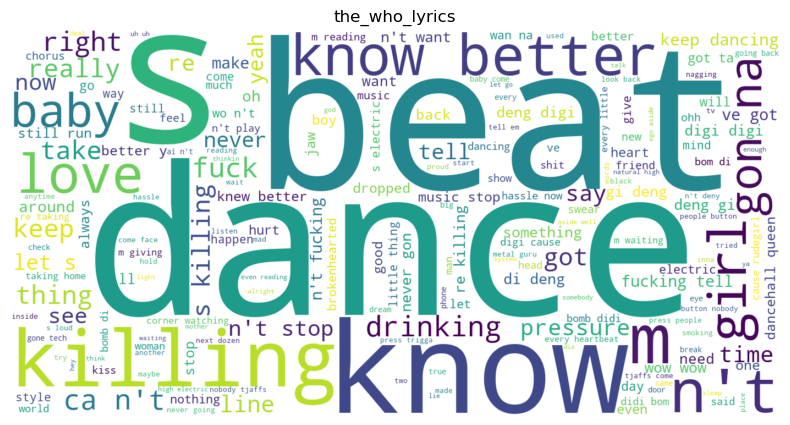

Saved to: figures\wordcloud_the_who_lyrics.png


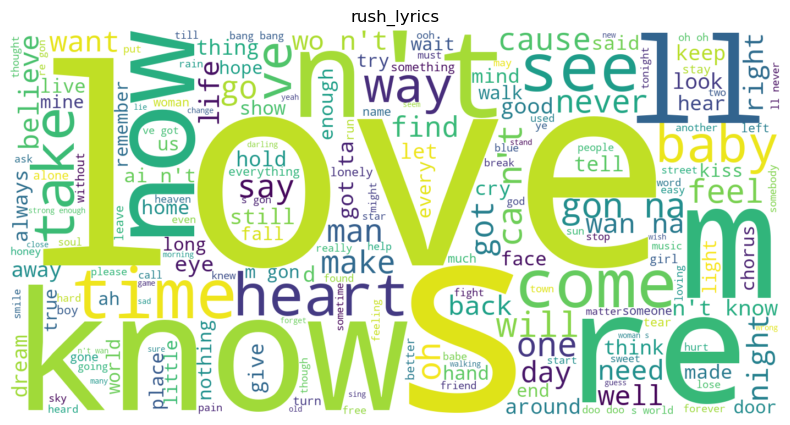

Saved to: figures\wordcloud_rush_lyrics.png


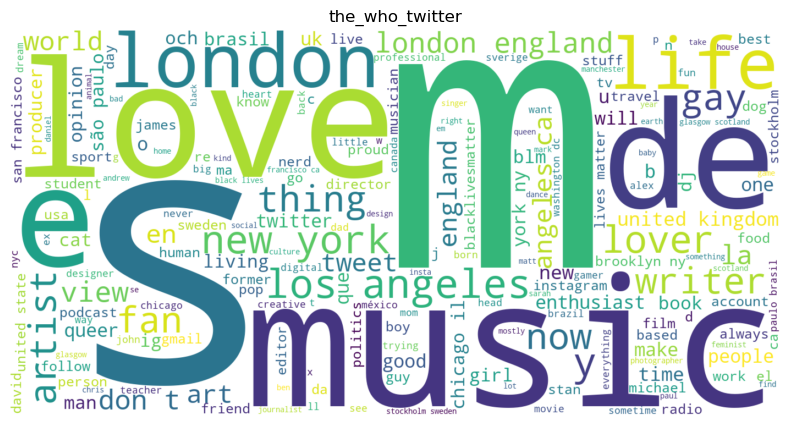

Saved to: figures\wordcloud_the_who_twitter.png


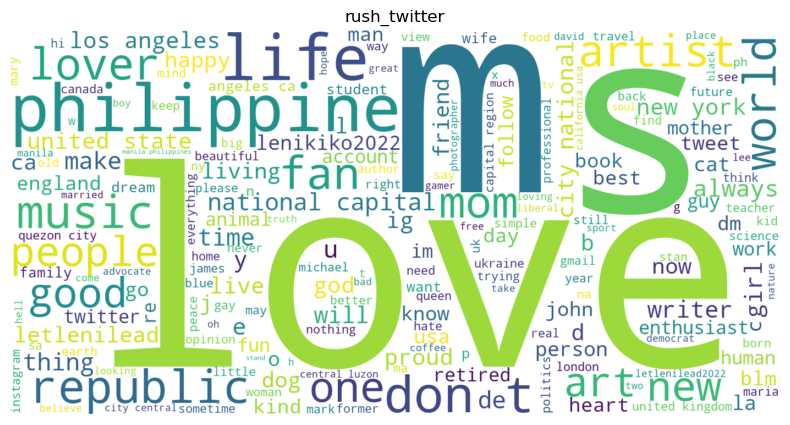

Saved to: figures\wordcloud_rush_twitter.png


In [9]:
def show_wordcloud(name, token_list):
    if not token_list:
        print(f"{name}: no tokens, skipping")
        return
    text = " ".join(token_list)
    wc = WordCloud(width=1400, height=700, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(name)
    out_file = FIG_DIR / f"wordcloud_{name}.png"
    plt.savefig(out_file, bbox_inches="tight", dpi=180)
    plt.show()
    print(f"Saved to: {out_file}")

# create and save a word cloud for each corpus
for corpus_name, token_list in tokens.items():
    show_wordcloud(corpus_name, token_list)

### Conclusion
This analysis compared lyrical and Twitter language for The Who and Rush using cleaned, tokenized corpora. Rush lyrics showed far more total tokens yet a lower type–token ratio, indicating greater repetition. Twitter corpora for both artists were immense and contained large sets of unique tokens, reflecting diverse follower bios. Word clouds highlighted prominent vocabulary differences across groups. Together, these findings illustrate how artist output and fan communities diverge linguistically, offering meaningful insight into audience engagement and stylistic tendencies.
